# Feature Extraction (Standard Features)

**Author**: Maleakhi Agung Wijaya  
**Email**: maw219@cam.ac.uk  
**Description**: This file contains code for extracting standard features, using conchology domain knowledge. We evaluate the performance of these features.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px
import plotly.graph_objects as go
import scipy.io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
import cv2
import os
import re
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, backend as K, callbacks

In [2]:
%run Utilities.ipynb

## Load Dataset

In this section, we will load previously extracted features, following feature extraction steps described in Zhang et al. (https://www.nature.com/articles/s41597-019-0230-3.pdf). The goal of the project is to build a classifier better than their method through exploring different feature extraction method.

In [3]:
# Load data (contains data that we constructed after feature extraction)
X_color, y_color = load_domain_knowledge_data(color_domain_knowledge)
X_shape, y_shape = load_domain_knowledge_data(shape_domain_knowledge)
X_texture, y_texture = load_domain_knowledge_data(texture_domain_knowledge)
X_all, y_all = load_domain_knowledge_data(all_domain_knowledge)

In [4]:
print(f"X_color: {X_color.shape}")
print(f"X_shape: {X_shape.shape}")
print(f"X_texture: {X_texture.shape}")
print(f"X_all: {X_all.shape}")

X_color: (1340, 12)
X_shape: (1340, 142)
X_texture: (1340, 4000)
X_all: (1340, 164)


## Extract Edge Features

We still need to extract edge features to complement the domain knowledge features.

In [5]:
# Load shell image data
filenames = sorted(os.listdir(SHELL_IMAGES_DATA))
X_species, y_species = preprocess_x_y(filenames)

In [6]:
X_edge = []
y_edge = y_species

# Get feature descriptors from all images
for X in tqdm(X_species):
    X_a = X[0] # A position
    X_b = X[1]
    
    pca = PCA(n_components=.8)
    
    # Open the image in gray scale
    edge_img_a = extract_canny_edge(os.path.join(SHELL_IMAGES_DATA, X_a))
    edge_img_b = extract_canny_edge(os.path.join(SHELL_IMAGES_DATA, X_b))
    edge_img_a = cv2.resize(edge_img_a, (300, 400))
    
    edge_img_b = cv2.resize(edge_img_b, (300, 400))

    X_edge.append(np.concatenate((edge_img_a, edge_img_b), axis=1))

In [7]:
# flatten everything
X_edge_flatten = []
for x in X_edge:
    X_edge_flatten.append(x.flatten())

In [8]:
pca = PCA(n_components=50)
X_edge_pca = pca.fit_transform(X_edge_flatten)

In [9]:
scaler = StandardScaler()
X_edge_pca_whitening = scaler.fit_transform(X_edge_pca)

## Preprocessing

In this section, we further expand the feature sets, introducing whitening and dimensionality reduction using PCA when appropriate. Experimentation are set to fairly compare performance with pipeline discussed in the Zhang et al. paper.

In [10]:
scaler = StandardScaler()
X_color_whitening = scaler.fit_transform(X_color)
y_color_whitening = y_color

X_shape_whitening = scaler.fit_transform(X_shape)
y_shape_whitening = y_shape

pca = PCA(n_components=0.99)
X_texture_pca = pca.fit_transform(scaler.fit_transform(X_texture))
y_texture_pca = y_texture
X_texture_pca_whitening = scaler.fit_transform(X_texture_pca)
y_texture_pca_whitening = y_texture

In [11]:
print(f"Number of components explaining 99% variance {X_texture_pca.shape[1]}")

Number of components explaining 99% variance 14


## Evaluation 
In this section, we train classifiers and evaluate the performance of the classifiers using the domain knowledge features in isolation and in combination.


### Standard ML Models
The following consider dummy classifier, SVC, and random forest.

In [29]:
## Hyperparameter configurations and result storage
param_grid_svc = {
    # random search varying the parameter
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': ["scale", "auto"], 
    'kernel': ["rbf", "linear"]
}

param_dummy = {
    "strategy": ["most_frequent"] # baseline
}

param_grid_rf = { 
    'n_estimators': np.random.randint(10, 500, 10),
    'criterion' :['gini', 'entropy']
}

# Used to store results for different feature sets
list_dict_results = []

In [32]:
## Loop configuration
feature_sets = [
    (X_all, y_all),
    (X_color, y_color),
    (X_shape, y_shape),
    (X_color_whitening, y_color_whitening),
    (X_shape_whitening, y_shape_whitening),
    (X_texture_pca, y_texture_pca),
    (X_texture_pca_whitening, y_texture_pca_whitening),
    (X_edge_pca_whitening, y_species)
]
feature_sets_name = [
    "all",
    "color",
    "shape",
    "color_whiten",
    "shape_whiten",
    "texture_pca",
    "texture_pca_whiten",
    "canny_edge"
]

## Classifier and hyperparameter loops
param_grids = [param_dummy, param_grid_svc, param_grid_rf]
classifiers_name = ["dummy", "svc", "rf"]
classifiers = [DummyClassifier(), SVC(), RandomForestClassifier()]
cmaps = [None, "plasma", "viridis"]

**************************************************
all
------------------------------
dummy
Accuracy: 0.007462686567164178
F1: 0.00011055831951354338

------------------------------
svc
Accuracy: 0.8276119402985074
F1: 0.8148400852878463


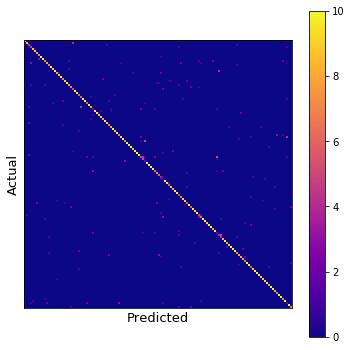


------------------------------
rf
Accuracy: 0.7925373134328357
F1: 0.772139303482587


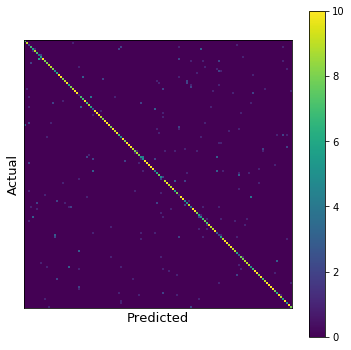


**************************************************
color
------------------------------
dummy
Accuracy: 0.007462686567164178
F1: 0.00011055831951354338

------------------------------
svc
Accuracy: 0.6007462686567164
F1: 0.5746517412935322


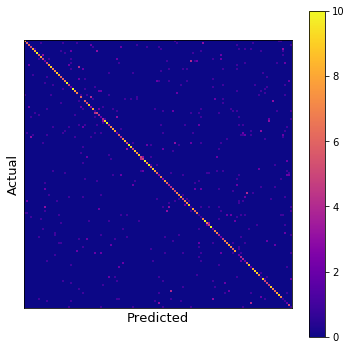


------------------------------
rf
Accuracy: 0.5455223880597015
F1: 0.5097301371928238


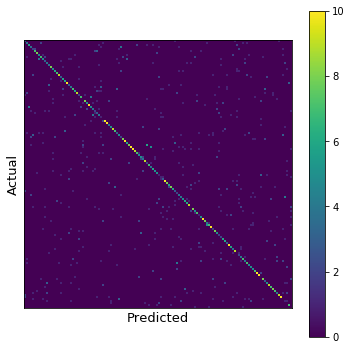


**************************************************
shape
------------------------------
dummy
Accuracy: 0.007462686567164178
F1: 0.00011055831951354338

------------------------------
svc
Accuracy: 0.75
F1: 0.7286353944562899


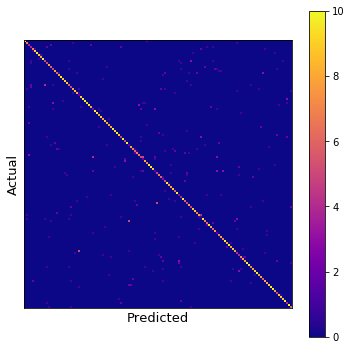


------------------------------
rf
Accuracy: 0.7350746268656716
F1: 0.7108031272210376


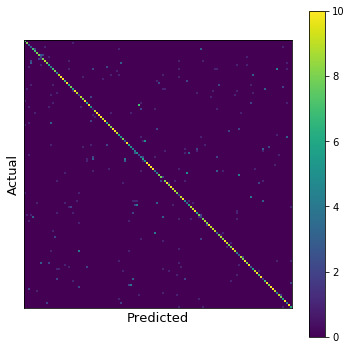


**************************************************
color_whiten
------------------------------
dummy
Accuracy: 0.007462686567164178
F1: 0.00011055831951354338

------------------------------
svc
Accuracy: 0.6164179104477612
F1: 0.5903233830845771


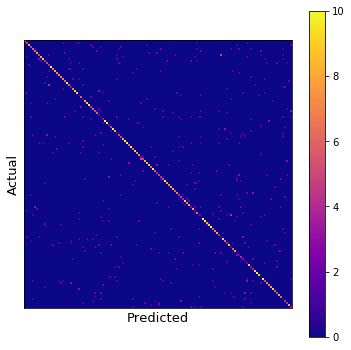


------------------------------
rf
Accuracy: 0.5567164179104477
F1: 0.5217768301350391


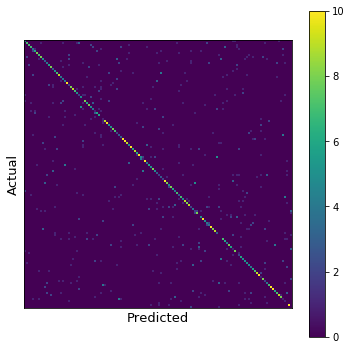


**************************************************
shape_whiten
------------------------------
dummy
Accuracy: 0.007462686567164178
F1: 0.00011055831951354338

------------------------------
svc
Accuracy: 0.7440298507462686
F1: 0.7271547026770907


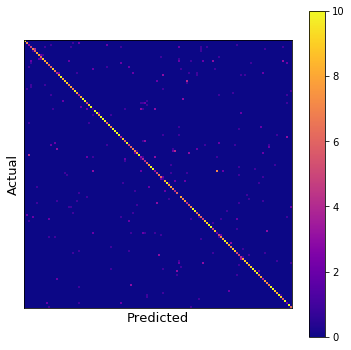


------------------------------
rf
Accuracy: 0.726865671641791
F1: 0.7004750059227671


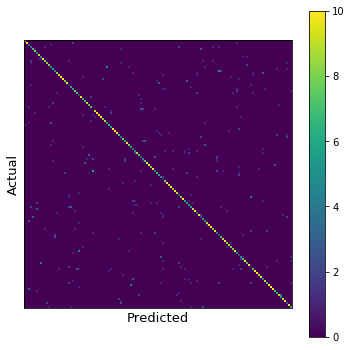


**************************************************
texture_pca
------------------------------
dummy
Accuracy: 0.007462686567164178
F1: 0.00011055831951354338

------------------------------
svc
Accuracy: 0.2328358208955224
F1: 0.20467187870172943


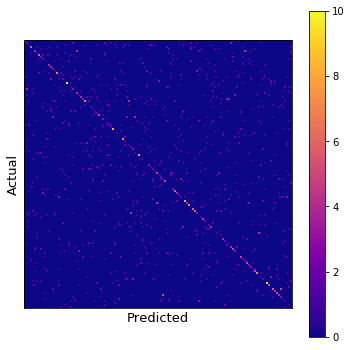


------------------------------
rf
Accuracy: 0.19850746268656716
F1: 0.16526189399323726


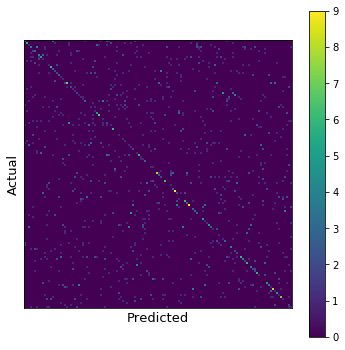


**************************************************
texture_pca_whiten
------------------------------
dummy
Accuracy: 0.007462686567164178
F1: 0.00011055831951354338

------------------------------
svc
Accuracy: 0.1850746268656716
F1: 0.1580300876569533


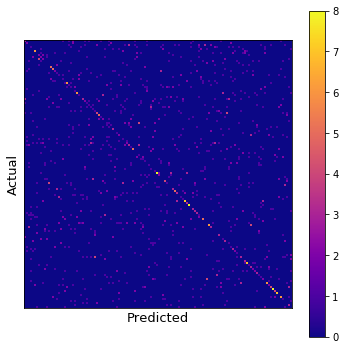


------------------------------
rf
Accuracy: 0.1917910447761194
F1: 0.16046671404880358


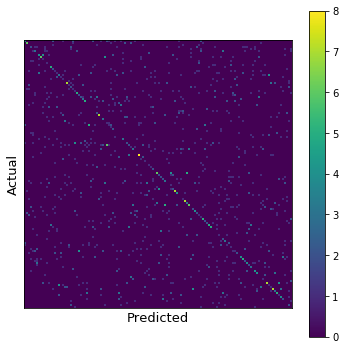


**************************************************
canny_edge
------------------------------
dummy
Accuracy: 0.007462686567164178
F1: 0.00011055831951354338

------------------------------
svc
Accuracy: 0.8305970149253732
F1: 0.8173560767590617


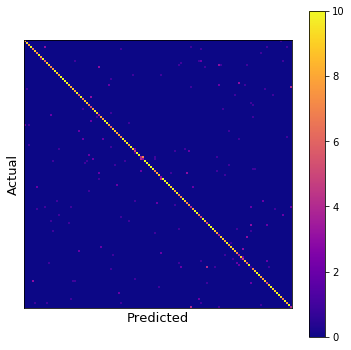


------------------------------
rf
Accuracy: 0.7955223880597014
F1: 0.7752736318407959


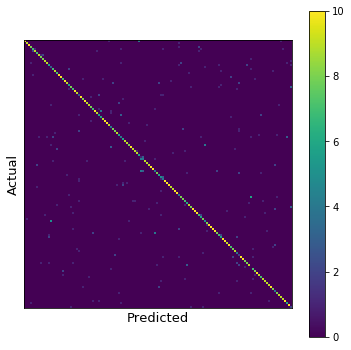

In [33]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    # Iterate over different classifiers
    for classifier, classifier_name, param_grid, cmap in zip(classifiers, 
                                                             classifiers_name, 
                                                             param_grids,
                                                             cmaps):
        print("-"*30)
        print(classifier_name)

        list_acc, list_cm, list_f1, list_cv_results = nested_cv_sklearn(classifier, param_grid, X, y, 5)
        # Add data to dict_results
        dict_results["accuracy"].append(list_acc)
        dict_results["f1"].append(list_f1)
        dict_results["cv_results"].append(list_cv_results)
        dict_results["cm"].append(list_cm)

        # Display accuracy, f1, confusion matrix
        print(f"Accuracy: {np.mean(list_acc)}")
        print(f"F1: {np.mean(list_f1)}")
        cm = sum(list_cm)

        if classifier_name != "dummy":
            plot_confusion_matrix(cm, cmap=cmap)

        print()
    
    list_dict_results.append(dict_results)

### Neural Networks

The following consider simple multilayer perceptron.

In [ ]:
param_grid_ffnn = { 
    'layer1_filters': [16, 32, 64, 128, 256],
    'layer2_filters': [16, 32, 64, 128, 256],
    'lr': np.random.uniform(0, 1, 5)
}

In [20]:
## Loop configuration
feature_sets = [
    (X_all, y_all-1),
    (X_color, y_color-1),
    (X_shape, y_shape-1),
    (X_color_whitening, y_color_whitening-1),
    (X_shape_whitening, y_shape_whitening-1),
    (X_texture_pca, y_texture_pca-1),
    (X_texture_pca_whitening, y_texture_pca_whitening-1),
    (X_edge_pca_whitening, y_all-1)
]
feature_sets_name = [
    "all",
    "color",
    "shape",
    "color_whiten",
    "shape_whiten",
    "texture_pca",
    "texture_pca_whiten",
    "canny_edge"
]

list_dict_results = []

In [21]:
# we use early stopping to prevent overfitting

batch_size = 64
no_epochs = 200

**************************************************
all
Accuracy: 0.8171641791044776
F1: 0.7787443733712389


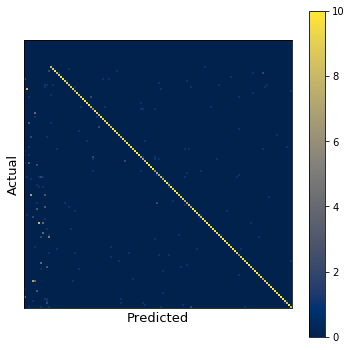


**************************************************
color
Accuracy: 0.007462686567164178
F1: 0.00011055831951354338


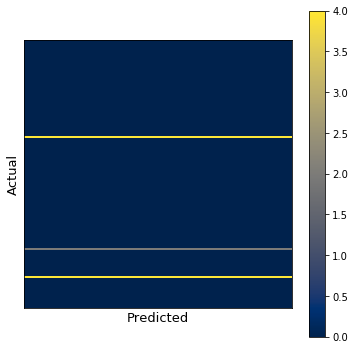


**************************************************
shape
Accuracy: 0.03955223880597015
F1: 0.019966635558918984


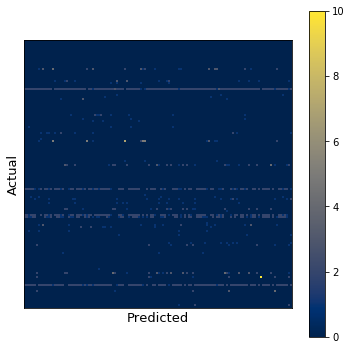


**************************************************
color_whiten
Accuracy: 0.5373134328358209
F1: 0.48283948224246726


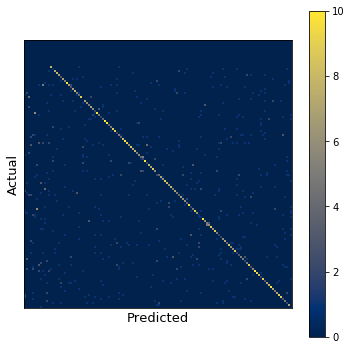


**************************************************
shape_whiten
Accuracy: 0.7238805970149255
F1: 0.683470741530443


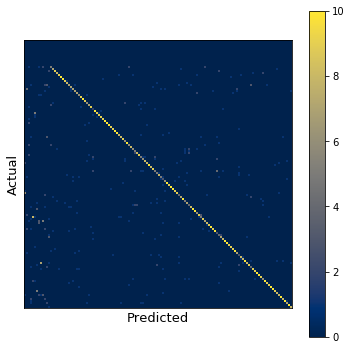


**************************************************
texture_pca
Accuracy: 0.31865671641791044
F1: 0.281924899312959


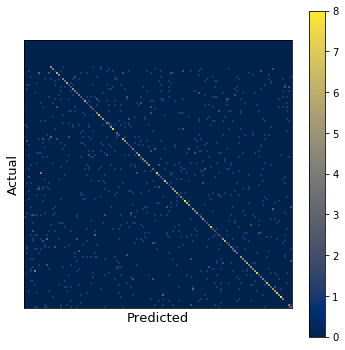


**************************************************
texture_pca_whiten
Accuracy: 0.3649253731343284
F1: 0.3269043974267855


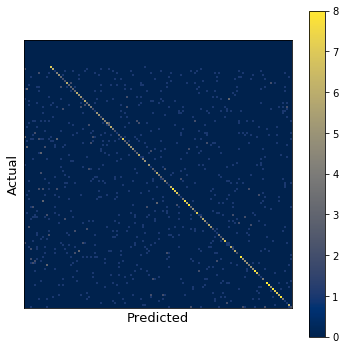


**************************************************
canny_edge
Accuracy: 0.8328358208955224
F1: 0.7965413193771401


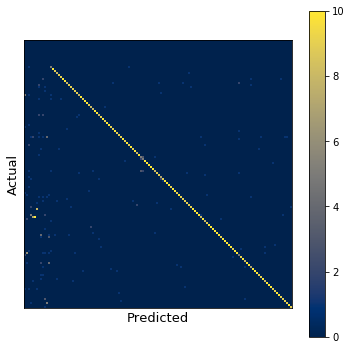

In [23]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    
    # Neural network training
    X = np.array(X)
    y = np.array(y)
    
    for train, test in kfold.split(X, y):
        grid_models = []
        performance = []
        for n1 in param_grid_ffnn["layer1_filters"]:
            for n2 in param_grid_ffnn["layer2_filters"]:
                for lr in param_grid_ffnn["lr"]:
                    model = keras.Sequential(
                            [
                                layers.Dense(n1, activation="relu"),
                                layers.Dense(n2, activation="relu"),
                                layers.Dense(134, activation="softmax"),
                            ]
                        )
                    optimizer = keras.optimizers.Adam(learnin_rate=lr)
                    
                    model.compile(loss="sparse_categorical_crossentropy",
                                 optimizer=optimizer,
                                 metrics=["accuracy"])

                    # Valid data
                    valid_range = int(0.2 * len(train))
                    valid = train[:valid_range]
                    train = train[valid_range:]
                    test_range = int(0.1 * len(valid))
                    test_inner = valid[:test_range]
                    valid = valid[test_range:]

                    # Early stopping callbacks
                    early_stopping = tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss', min_delta=0, patience=20,
                        mode="auto", restore_best_weights=False
                    )

                    # Fit data to model
                    history = model.fit(X[train], y[train],
                              batch_size=batch_size,
                              epochs=no_epochs, verbose=0, 
                              validation_data=(X[valid], y[valid]),
                              callbacks=[early_stopping])
                    
                    pred = model.predict(X[test_inner])
                    pred = np.argmax(pred, axis=1)
                    acc_inner = accuracy_score(pred, y[test_inner])
                    grid_models.append(model)
                    performance.append(acc_inner)
        
        # Refit the best model
        model = grid_models[np.argmax(performance)]
        
        # Generate generalisation metrics
        pred = model.predict(X[test])
        pred = np.argmax(pred, axis=1)
        cm = confusion_matrix(pred, y[test])
        acc = accuracy_score(pred, y[test])
        f1 = f1_score(pred, y[test], average="macro")
        
        # Add data to dict results
        dict_results["accuracy"].append(acc)
        dict_results["f1"].append(f1)
        dict_results["cm"].append(cm)
        
    # Display accuracy, f1, confusion matrix
    print(f"Accuracy: {np.mean(dict_results['accuracy'])}")
    print(f"F1: {np.mean(dict_results['f1'])}")
    plot_confusion_matrix(sum(dict_results['cm']), cmap="cividis")

    print()

    list_dict_results.append(dict_results)